# DAS Ngram analyse

----

## Overview

1. Import packages, stopwords and the data
2. Check the data and perform necessary cleaning steps. This will vary with each dataset
3. EDA (Explorative Data Analysis) Do word counts, frequency distributions etc
    - Word Frequency for total
    - Word Frequency per source
    - Make ngrams per answer
4. If needed, another round of cleaning

## Import modules, data and stopwords
----

In [1]:
#import NLP modules
from nltk import FreqDist
import spacy

#modules for cleaning
import string
import re
import unicodedata

#imports for data handling
from pathlib import Path
import pandas as pd
import numpy as np
pd.set_option("display.max_colwidth", 200)


In [2]:
#load spacy tokenizer
nlp = spacy.load('nl_core_news_sm')

In [3]:
#define path for data

#private customers
na_afloop_p = Path(r"C:\Thuiswerken\DAS\Rechtshulp na afloop\Topic Modeling Rechtshulp na afloop\Data\na_afloop_particulier_29112020.csv")
#business customers
na_afloop_z = Path(r"C:\Thuiswerken\DAS\Rechtshulp na afloop\Topic Modeling Rechtshulp na afloop\Data\na_afloop_zakelijk_29112020.csv")
#halfway survey private
tussentijds_p = Path(r"C:\Thuiswerken\DAS\Rechtshulp na afloop\Topic Modeling Rechtshulp na afloop\Data\tussentijds_particulier_29112020.csv")
#halfway survey
tussentijds_z = Path(r"C:\Thuiswerken\DAS\Rechtshulp na afloop\Topic Modeling Rechtshulp na afloop\Data\tussentijds_zakelijk_29112020.csv")


In [4]:
#load Dutch and Enlgish stopwords to list

stopbestand = Path(r"C:\Users\kvandoorn\MWM2 B.V\MWM2 - Documenten\Datalab\3 Werkwijze\Datasets\Textanalyse\NL_stopwoorden.txt")
stopwoorden = [line.rstrip('\n') for line in open(stopbestand) if line != 'niet\n']

stopbestand_EN = Path(r"C:\Users\kvandoorn\MWM2 B.V\MWM2 - Documenten\Datalab\3 Werkwijze\Datasets\Textanalyse\EN_stopwoorden.txt")
stopwoorden_EN = [line.rstrip('\n') for line in open(stopbestand_EN)]

stopwoorden.extend(stopwoorden_EN)

In [5]:
#load files into pandas, select columns, rename columns

kolommen = ['NPS','NPSPROMOTER','NPSPASSIVES','NPSDETRACTORS','V10','V11','V12']
kolommen_nieuw = ['NPS','NPSPROMOTER','NPSPASSIVES','NPSDETRACTORS','GEVOEL','GEVOELPOSITIEF','GEVOELNEGATIEF']
rename_dict = dict(zip(kolommen, kolommen_nieuw))
#private data
data_afloop_p = pd.read_csv(na_afloop_p, sep=";", encoding="utf-8", usecols=(kolommen))
data_afloop_p.rename(columns=rename_dict, inplace=True)
#business_data
data_afloop_z = pd.read_csv(na_afloop_z, sep=";", encoding="utf-8", usecols=(kolommen))
data_afloop_z.rename(columns=rename_dict, inplace=True)
#data.columns = ['text','source','influencer']
#data.dropna(axis=0, how='any', subset=['text'], inplace=True)

In [6]:
data_afloop_p.head()

NPS  \
0                         5   
1                         9   
2                         8   
3                         7   
4  10 = zeer waarschijnlijk   

                                                                                                                        NPSPROMOTER  \
0                                                                                                                            n.v.t.   
1  De service was heel erg goed. Ze bleven goed in contact en antwoorden altijd op tijd terug. Ze krijgen dingen ook goed geregeld.   
2                                                                                                                            n.v.t.   
3                                                                                                                            n.v.t.   
4                                                                                   Hele fijne vrouw die mij begrijpt en goed helpt   

                   NPSPASSIVES  \
0                       n.v.t.   
1                       n.v.t.   
2  Meer feedback naar mij toe.   
3                          NaN   
4                       n.v.t.   

                                                                                                                                NPSDETRACTORS  \
0  De extra betaling die erbij kwam voor klein beetje advies waar meteen over gesproken werd viel mij tegen Waar betaal je dan immers voor ??   
1                                                                                                                                      n.v.t.   
2                                                                                                                                      n.v.t.   
3                                                                                                                                      n.v.t.   
4                                                                                                                                      n.v.t.   

                GEVOEL  \
0  Overwegend negatief   
1  Overwegend positief   
2  Overwegend positief   
3             Neutraal   
4             Neutraal   

                                                                                          GEVOELPOSITIEF  \
0                                                                                                 n.v.t.   
1  Alles werd heel goed uitgevoerd en uiteindelijk werd het ook opgelost, daar zijn we ook erg blij mee.   
2                                            De jurist zat met de schuld vraag goed met mij op een lijn.   
3                                                                                                 n.v.t.   
4                                                                                                 n.v.t.   

                                                                                                                                              GEVOELNEGATIEF  
0  De zaak heb ik uiteindelijk zelf op andere manier opgelost omdat er meteen over extra bijdrage  100 euro werd gesproken Waar betaal ik dan immers voor???  
1                                                                                                                                                     n.v.t.  
2                                                                                                                                                     n.v.t.  
3                                                                                                                                                     n.v.t.  
4                                                                                                                                                     n.v.t.

----
## Cleaning the data

In [7]:
#replace default "n.v.t." with NaN
data_afloop_p = data_afloop_p.replace({'n.v.t.':np.nan})

#add ID column
data_afloop_p["ID"] = data_afloop_p.reset_index().index

### Transpose the data

In [8]:
#transpose data to get one column with all the text.
data_p_trans = pd.melt(data_afloop_p, id_vars=["ID", "NPS", "GEVOEL"])
data_p_trans

ID                       NPS               GEVOEL        variable  \
0           0                         5  Overwegend negatief     NPSPROMOTER   
1           1                         9  Overwegend positief     NPSPROMOTER   
2           2                         8  Overwegend positief     NPSPROMOTER   
3           3                         7             Neutraal     NPSPROMOTER   
4           4  10 = zeer waarschijnlijk             Neutraal     NPSPROMOTER   
...       ...                       ...                  ...             ...   
117945  23585                         5  Overwegend positief  GEVOELNEGATIEF   
117946  23586                         7  Overwegend positief  GEVOELNEGATIEF   
117947  23587                         9  Overwegend positief  GEVOELNEGATIEF   
117948  23588                         5             Neutraal  GEVOELNEGATIEF   
117949  23589  10 = zeer waarschijnlijk  Overwegend positief  GEVOELNEGATIEF   

                                                                                                                                   value  
0                                                                                                                                    NaN  
1       De service was heel erg goed. Ze bleven goed in contact en antwoorden altijd op tijd terug. Ze krijgen dingen ook goed geregeld.  
2                                                                                                                                    NaN  
3                                                                                                                                    NaN  
4                                                                                        Hele fijne vrouw die mij begrijpt en goed helpt  
...                                                                                                                                  ...  
117945                                                                                                                               NaN  
117946                                                                                                                               NaN  
117947                                                                                                                               NaN  
117948                                                                                                                               NaN  
117949                                                                                                                               NaN  

[117950 rows x 5 columns]

In [9]:
#Drop NaN values
data_p_trans.dropna(inplace=True)

In [10]:
# function to remove accented characters
def remove_accented_chars(text):
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

In [11]:
#fucntion for removing accents tokenizing only alphanumeric words not present in stopwords
def clean_tokens(sentence):
    doc = unicodedata.normalize('NFKD', sentence).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    doc = nlp.tokenizer(doc)
    tokenized = [w.norm_.lower() for w in doc if w.is_alpha and not w.lemma_ in stopwoorden]
    return tokenized

In [12]:
# function for first round of text cleaning techniques

def clean_text_round1(text):
    '''Make text lowercase, remove URLs, remove @mentions, remove text in square brackets, remove punctuation 
    and remove words containing numbers.'''
    text = text.lower()
    #text = re.sub(r'http\S+', '', text)
    #text = re.sub(r'@\w*', '', text)
    #text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text   

In [13]:
#tokenizing
data_p_trans['clean'] = data_p_trans['value'].apply(lambda x: clean_tokens(x))
data_p_trans.head()

ID                       NPS               GEVOEL     variable  \
1   1                         9  Overwegend positief  NPSPROMOTER   
4   4  10 = zeer waarschijnlijk             Neutraal  NPSPROMOTER   
5   5  10 = zeer waarschijnlijk  Overwegend positief  NPSPROMOTER   
7   7                         9  Overwegend positief  NPSPROMOTER   
9   9                         9  Overwegend positief  NPSPROMOTER   

                                                                                                                              value  \
1  De service was heel erg goed. Ze bleven goed in contact en antwoorden altijd op tijd terug. Ze krijgen dingen ook goed geregeld.   
4                                                                                   Hele fijne vrouw die mij begrijpt en goed helpt   
5                                                                                          Duidelijke communicatie en snel reageren   
7                                                                              Goed luisteren en meedenken én ….ze sprak italiaans!   
9                                                              Geschertste probleem werd snel en vakkundig opgenomen en beeantwoord   

                                                                                                         clean  
1  [service, heel, erg, goed, bleven, goed, contact, antwoorden, tijd, terug, krijgen, dingen, goed, geregeld]  
4                                                                        [fijne, vrouw, begrijpt, goed, helpt]  
5                                                                   [duidelijke, communicatie, snel, reageren]  
7                                                               [goed, luisteren, meedenken, sprak, italiaans]  
9                                             [geschertste, probleem, snel, vakkundig, opgenomen, beeantwoord]

In [14]:
#function to make ngrams
def seq_ngrams(xs, n):
    return [tuple(xs[i:i+n]) for i in range(len(xs)-n+1)]

In [20]:
#apply ngram function to make bigrams
data_p_trans['bigrams'] = data_p_trans['clean'].apply(lambda x: seq_ngrams(x, 2))
data_p_trans.head()

ID                       NPS               GEVOEL     variable  \
1   1                         9  Overwegend positief  NPSPROMOTER   
4   4  10 = zeer waarschijnlijk             Neutraal  NPSPROMOTER   
5   5  10 = zeer waarschijnlijk  Overwegend positief  NPSPROMOTER   
7   7                         9  Overwegend positief  NPSPROMOTER   
9   9                         9  Overwegend positief  NPSPROMOTER   

                                                                                                                              value  \
1  De service was heel erg goed. Ze bleven goed in contact en antwoorden altijd op tijd terug. Ze krijgen dingen ook goed geregeld.   
4                                                                                   Hele fijne vrouw die mij begrijpt en goed helpt   
5                                                                                          Duidelijke communicatie en snel reageren   
7                                                                              Goed luisteren en meedenken én ….ze sprak italiaans!   
9                                                              Geschertste probleem werd snel en vakkundig opgenomen en beeantwoord   

                                                                                                         clean  \
1  [service, heel, erg, goed, bleven, goed, contact, antwoorden, tijd, terug, krijgen, dingen, goed, geregeld]   
4                                                                        [fijne, vrouw, begrijpt, goed, helpt]   
5                                                                   [duidelijke, communicatie, snel, reageren]   
7                                                               [goed, luisteren, meedenken, sprak, italiaans]   
9                                             [geschertste, probleem, snel, vakkundig, opgenomen, beeantwoord]   

                                                                                                                                                                                                   bigrams  
1  [(service, heel), (heel, erg), (erg, goed), (goed, bleven), (bleven, goed), (goed, contact), (contact, antwoorden), (antwoorden, tijd), (tijd, terug), (terug, krijgen), (krijgen, dingen), (dingen,...  
4                                                                                                                                     [(fijne, vrouw), (vrouw, begrijpt), (begrijpt, goed), (goed, helpt)]  
5                                                                                                                                     [(duidelijke, communicatie), (communicatie, snel), (snel, reageren)]  
7                                                                                                                      [(goed, luisteren), (luisteren, meedenken), (meedenken, sprak), (sprak, italiaans)]  
9                                                                                         [(geschertste, probleem), (probleem, snel), (snel, vakkundig), (vakkundig, opgenomen), (opgenomen, beeantwoord)]

In [21]:
data_p_trans.bigrams.explode().value_counts(normalize=True)

(goed, geholpen)         0.005470
(snelle, reactie)        0.002511
(goed, advies)           0.002379
(goede, communicatie)    0.001865
(snelle, afhandeling)    0.001769
                           ...   
(leggen, bellen)         0.000006
(regelen, vergoeding)    0.000006
(vraag, verzekering)     0.000006
(geweldig, begrip)       0.000006
(gebreken, wassen)       0.000006
Name: bigrams, Length: 100804, dtype: float64

In [22]:
#fucntion for removing accents tokenizing only lemmas not present in stopwords
def clean_lemmas(sentence):
    doc = unicodedata.normalize('NFKD', sentence).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    doc = nlp.tokenizer(doc)
    tokenized = [w.lemma_ for w in doc if w.is_alpha and not w.lemma_ in stopwoorden]
    return tokenized

In [23]:
data_p_trans_lemmas = data_p_trans.copy()
data_p_trans_lemmas['clean_lemmas'] = data_p_trans['value'].apply(lambda x: clean_lemmas(x))

In [24]:
data_p_trans_lemmas.head()

ID                       NPS               GEVOEL     variable  \
1   1                         9  Overwegend positief  NPSPROMOTER   
4   4  10 = zeer waarschijnlijk             Neutraal  NPSPROMOTER   
5   5  10 = zeer waarschijnlijk  Overwegend positief  NPSPROMOTER   
7   7                         9  Overwegend positief  NPSPROMOTER   
9   9                         9  Overwegend positief  NPSPROMOTER   

                                                                                                                              value  \
1  De service was heel erg goed. Ze bleven goed in contact en antwoorden altijd op tijd terug. Ze krijgen dingen ook goed geregeld.   
4                                                                                   Hele fijne vrouw die mij begrijpt en goed helpt   
5                                                                                          Duidelijke communicatie en snel reageren   
7                                                                              Goed luisteren en meedenken én ….ze sprak italiaans!   
9                                                              Geschertste probleem werd snel en vakkundig opgenomen en beeantwoord   

                                                                                                         clean  \
1  [service, heel, erg, goed, bleven, goed, contact, antwoorden, tijd, terug, krijgen, dingen, goed, geregeld]   
4                                                                        [fijne, vrouw, begrijpt, goed, helpt]   
5                                                                   [duidelijke, communicatie, snel, reageren]   
7                                                               [goed, luisteren, meedenken, sprak, italiaans]   
9                                             [geschertste, probleem, snel, vakkundig, opgenomen, beeantwoord]   

                                                                                                                                                                                                   bigrams  \
1  [(service, heel), (heel, erg), (erg, goed), (goed, bleven), (bleven, goed), (goed, contact), (contact, antwoorden), (antwoorden, tijd), (tijd, terug), (terug, krijgen), (krijgen, dingen), (dingen,...   
4                                                                                                                                     [(fijne, vrouw), (vrouw, begrijpt), (begrijpt, goed), (goed, helpt)]   
5                                                                                                                                     [(duidelijke, communicatie), (communicatie, snel), (snel, reageren)]   
7                                                                                                                      [(goed, luisteren), (luisteren, meedenken), (meedenken, sprak), (sprak, italiaans)]   
9                                                                                         [(geschertste, probleem), (probleem, snel), (snel, vakkundig), (vakkundig, opgenomen), (opgenomen, beeantwoord)]   

                                                                                                   clean_lemmas  
1  [service, heel, erg, goed, blijven, goed, contact, antwoorden, tijd, terug, krijgen, dingen, goed, geregeld]  
4                                                                        [fijn, vrouw, begrijpen, goed, helpen]  
5                                                                     [duidelijk, communicatie, snel, reageren]  
7                                                              [goed, luisteren, meedenken, spreken, italiaans]  
9                                              [geschertste, probleem, snel, vakkundig, opgenomen, beeantwoord]

In [25]:
data_p_trans_lemmas['bigrams'] = data_p_trans_lemmas['clean_lemmas'].apply(lambda x: seq_ngrams(x, 2))
data_p_trans_lemmas.head()

ID                       NPS               GEVOEL     variable  \
1   1                         9  Overwegend positief  NPSPROMOTER   
4   4  10 = zeer waarschijnlijk             Neutraal  NPSPROMOTER   
5   5  10 = zeer waarschijnlijk  Overwegend positief  NPSPROMOTER   
7   7                         9  Overwegend positief  NPSPROMOTER   
9   9                         9  Overwegend positief  NPSPROMOTER   

                                                                                                                              value  \
1  De service was heel erg goed. Ze bleven goed in contact en antwoorden altijd op tijd terug. Ze krijgen dingen ook goed geregeld.   
4                                                                                   Hele fijne vrouw die mij begrijpt en goed helpt   
5                                                                                          Duidelijke communicatie en snel reageren   
7                                                                              Goed luisteren en meedenken én ….ze sprak italiaans!   
9                                                              Geschertste probleem werd snel en vakkundig opgenomen en beeantwoord   

                                                                                                         clean  \
1  [service, heel, erg, goed, bleven, goed, contact, antwoorden, tijd, terug, krijgen, dingen, goed, geregeld]   
4                                                                        [fijne, vrouw, begrijpt, goed, helpt]   
5                                                                   [duidelijke, communicatie, snel, reageren]   
7                                                               [goed, luisteren, meedenken, sprak, italiaans]   
9                                             [geschertste, probleem, snel, vakkundig, opgenomen, beeantwoord]   

                                                                                                                                                                                                   bigrams  \
1  [(service, heel), (heel, erg), (erg, goed), (goed, blijven), (blijven, goed), (goed, contact), (contact, antwoorden), (antwoorden, tijd), (tijd, terug), (terug, krijgen), (krijgen, dingen), (dinge...   
4                                                                                                                                   [(fijn, vrouw), (vrouw, begrijpen), (begrijpen, goed), (goed, helpen)]   
5                                                                                                                                      [(duidelijk, communicatie), (communicatie, snel), (snel, reageren)]   
7                                                                                                                  [(goed, luisteren), (luisteren, meedenken), (meedenken, spreken), (spreken, italiaans)]   
9                                                                                         [(geschertste, probleem), (probleem, snel), (snel, vakkundig), (vakkundig, opgenomen), (opgenomen, beeantwoord)]   

                                                                                                   clean_lemmas  
1  [service, heel, erg, goed, blijven, goed, contact, antwoorden, tijd, terug, krijgen, dingen, goed, geregeld]  
4                                                                        [fijn, vrouw, begrijpen, goed, helpen]  
5                                                                     [duidelijk, communicatie, snel, reageren]  
7                                                              [goed, luisteren, meedenken, spreken, italiaans]  
9                                              [geschertste, probleem, snel, vakkundig, opgenomen, beeantwoord]

In [26]:
data_p_trans_lemmas.bigrams.explode().value_counts().head(30)

(goed, helpen)               932
(snel, reactie)              586
(goed, advies)               400
(snel, afhandeling)          315
(goede, communicatie)        312
(heel, goed)                 276
(snel, reageren)             269
(duidelijk, communicatie)    268
(zaak, niet)                 259
(zaak, goed)                 258
(duidelijk, uitleg)          254
(serieus, genomen)           237
(hoogte, gehouden)           224
(snel, duidelijk)            205
(goed, resultaat)            198
(snel, helpen)               181
(niet, goed)                 179
(kennis, zaken)              170
(persoonlijk, contact)       169
(goed, contact)              166
(jurist, niet)               166
(telefonisch, contact)       164
(goed, hoogte)               163
(goede, service)             155
(goed, luisteren)            154
(weet, niet)                 153
(goed, afhandelen)           152
(goede, advies)              148
(snel, afhandelen)           147
(woord, staan)               146
Name: bigr

In [27]:
data_p_trans.bigrams.explode().value_counts().head(30)

(goed, geholpen)              915
(snelle, reactie)             420
(goed, advies)                398
(goede, communicatie)         312
(snelle, afhandeling)         296
(heel, goed)                  276
(zaak, niet)                  258
(zaak, goed)                  254
(duidelijke, communicatie)    246
(serieus, genomen)            236
(hoogte, gehouden)            224
(duidelijke, uitleg)          214
(goed, resultaat)             198
(snel, geholpen)              179
(niet, goed)                  177
(kennis, zaken)               170
(sneller, reageren)           168
(goed, contact)               166
(jurist, niet)                166
(goed, hoogte)                163
(telefonisch, contact)        157
(goede, service)              155
(weet, niet)                  153
(persoonlijk, contact)        147
(goed, afgehandeld)           147
(woord, gestaan)              139
(goed, snel)                  139
(goede, afhandeling)          135
(goede, uitleg)               127
(positief, res

In [28]:
#target = [('serieus', 'genomen')]

In [29]:
#data_p_trans_lemmas[data_p_trans_lemmas.bigrams.apply(lambda x: bool(set(x) & set(target)))].head(50)

In [30]:
npsgroups = data_p_trans_lemmas['variable'].value_counts().index.tolist()
npsgroups

['GEVOELPOSITIEF',
 'NPSPROMOTER',
 'NPSPASSIVES',
 'NPSDETRACTORS',
 'GEVOELNEGATIEF']

In [31]:
#data_p_trans_lemmas.loc[data_p_trans_lemmas['ID'] == 1]

ID NPS               GEVOEL        variable  \
1       1   9  Overwegend positief     NPSPROMOTER   
70771   1   9  Overwegend positief  GEVOELPOSITIEF   

                                                                                                                                  value  \
1      De service was heel erg goed. Ze bleven goed in contact en antwoorden altijd op tijd terug. Ze krijgen dingen ook goed geregeld.   
70771                             Alles werd heel goed uitgevoerd en uiteindelijk werd het ook opgelost, daar zijn we ook erg blij mee.   

                                                                                                             clean  \
1      [service, heel, erg, goed, bleven, goed, contact, antwoorden, tijd, terug, krijgen, dingen, goed, geregeld]   
70771                                             [heel, goed, uitgevoerd, uiteindelijk, opgelost, erg, blij, mee]   

                                                                                                                                                                                                       bigrams  \
1      [(service, heel), (heel, erg), (erg, goed), (goed, blijven), (blijven, goed), (goed, contact), (contact, antwoorden), (antwoorden, tijd), (tijd, terug), (terug, krijgen), (krijgen, dingen), (dinge...   
70771                                                                        [(heel, goed), (goed, uitvoeren), (uitvoeren, uiteindelijk), (uiteindelijk, oplossen), (oplossen, erg), (erg, blij), (blij, mee)]   

                                                                                                       clean_lemmas  
1      [service, heel, erg, goed, blijven, goed, contact, antwoorden, tijd, terug, krijgen, dingen, goed, geregeld]  
70771                                               [heel, goed, uitvoeren, uiteindelijk, oplossen, erg, blij, mee]

In [32]:
data_p_pro = data_p_trans_lemmas[(data_p_trans_lemmas['variable'] == 'NPSPROMOTER') | (data_p_trans_lemmas['variable'] == 'GEVOELPOSITIEF')]

In [33]:
data_p_pas = data_p_trans_lemmas[data_p_trans_lemmas['variable'] == 'NPSPASSIVES']

In [34]:
data_p_det = data_p_trans_lemmas[(data_p_trans_lemmas['variable'] == 'NPSDETRACTORS') | (data_p_trans_lemmas['variable'] == 'GEVOELNEGATIEF')]

In [35]:
data_p_pro.shape

(21228, 8)

In [36]:
data_p_pro.bigrams.explode().value_counts().head(30)

(goed, helpen)               863
(snel, reactie)              554
(goed, advies)               387
(goede, communicatie)        305
(snel, afhandeling)          299
(duidelijk, communicatie)    262
(duidelijk, uitleg)          246
(zaak, goed)                 229
(heel, goed)                 227
(hoogte, gehouden)           203
(goed, resultaat)            195
(snel, duidelijk)            194
(serieus, genomen)           180
(snel, helpen)               177
(goed, contact)              161
(kennis, zaken)              157
(goede, service)             154
(goed, hoogte)               152
(goede, advies)              144
(goed, afhandelen)           142
(goed, luisteren)            138
(goed, snel)                 136
(goede, afhandeling)         135
(woord, staan)               131
(niet, verwachten)           125
(goede, uitleg)              124
(resultaat, behalen)         123
(snel, afhandelen)           122
(snel, goed)                 121
(positief, resultaat)        116
Name: bigr

In [37]:
def count_opschonen(series):
    rijen = []
    count = 0
    for x in range(0, len(series.index)):
        for y in range(x + 1, len(series.index)):
            if series.index[x][0] in series.index[y]:
                count += 1
                if series.index[x][1] in series.index[y]:
                    count += 1
            if count == 2:
                series[x] += series[y]
                rijen.append(y)
            count = 0
    series.drop(series.index[rijen], inplace=True)
    return(series)

In [38]:
def ngram_chart(series, terms=30, name='', save=False):
    ngrams_list = series.explode().value_counts().head(terms)
    ngrams_list = count_opschonen(ngrams_list)
    ngrams_list.sort_values().plot.barh(width=.9, figsize=(10, 10))
    ngrams_list_full = series.explode().value_counts()
    ngrams_list_full.to_csv(name + '_full.csv', sep=";")
    count_opschonen(ngrams_list_full[:100]).to_csv(name + '_top100.csv', sep=";")
    plt.title(name)
    plt.ylabel('Bigram')
    plt.xlabel('# of Occurances')
    if save:
        plt.savefig(name + '.png', bbox_inches='tight')

def ngram_chart(series, terms=30, name='', save=False):
    ngrams_list = series.explode().value_counts().head(terms)
    ngrams_list.sort_values().plot.barh(width=.9, figsize=(10, 10))
    ngrams_list_full = series.explode().value_counts()
    ngrams_list_full.to_csv(name + '.csv', sep=";")
    plt.title(name)
    plt.ylabel('Bigram')
    plt.xlabel('# of Occurances')
    if save:
        plt.savefig(name + '.png', bbox_inches='tight')

In [39]:
#plotting
import matplotlib.pyplot as plt
%matplotlib inline

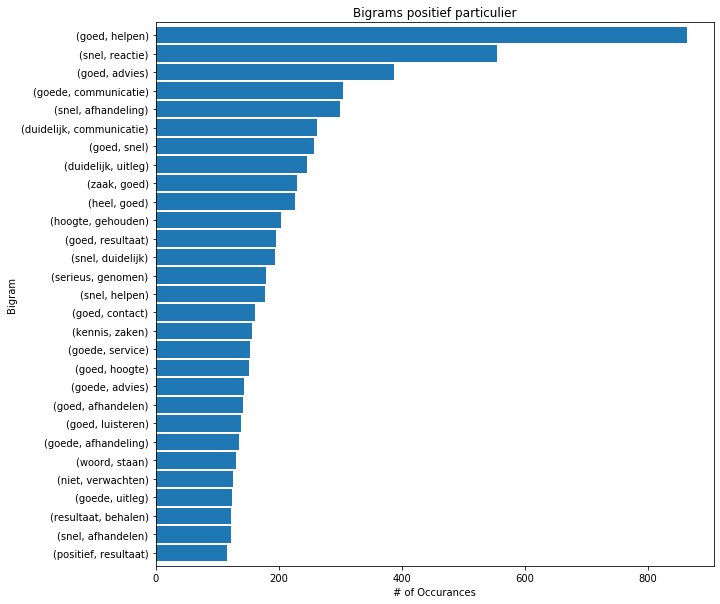

In [40]:
ngram_chart(data_p_pro.bigrams, 30, 'Bigrams positief particulier', True)

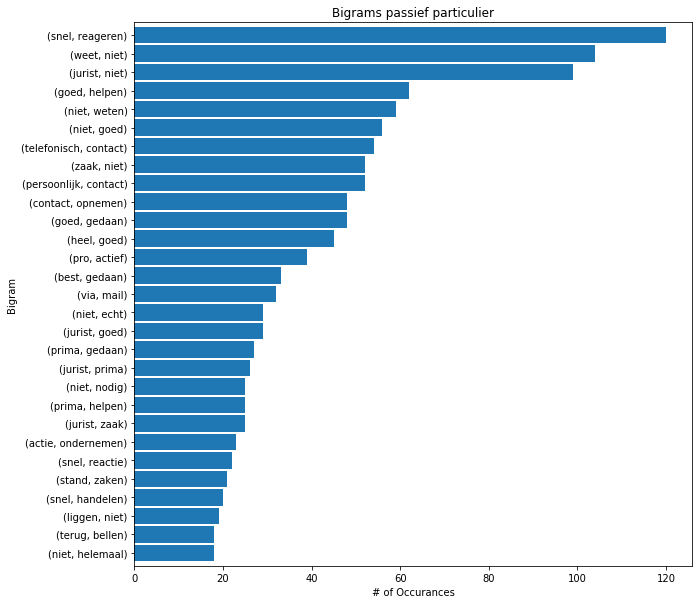

In [43]:
ngram_chart(data_p_pas.bigrams, 30, 'Bigrams passief particulier', True)

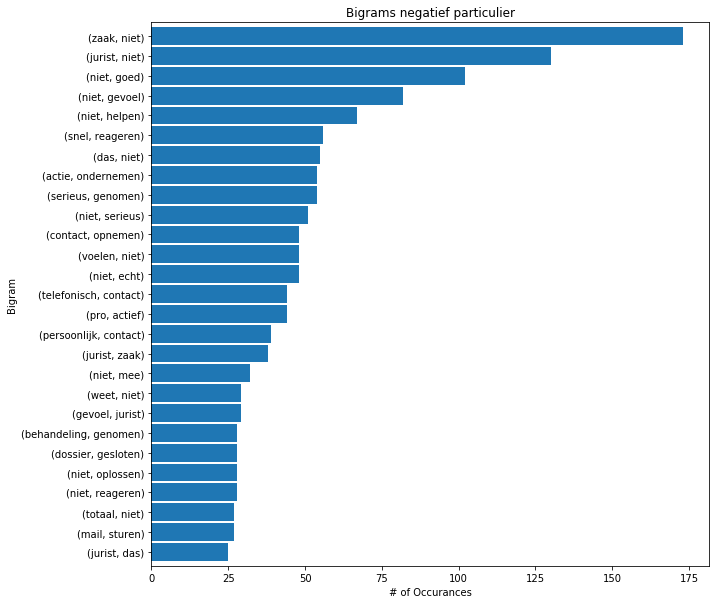

In [44]:
ngram_chart(data_p_det.bigrams, 30, 'Bigrams negatief particulier', True)

## Hetzelfde doen voor zakelijke data

In [45]:
#replace default "n.v.t." with NaN
data_afloop_z = data_afloop_z.replace({'n.v.t.':np.nan})
data_afloop_z.head()

NPS NPSPROMOTER  \
0                          8         NaN   
1                          8         NaN   
2  0 = zeer onwaarschijnlijk         NaN   
3                          8         NaN   
4                          8         NaN   

                                                                                                                                                                                NPSPASSIVES  \
0                                                                                                                                Hij kon mij niet verder helpen.  Dat was niet zijn schuld.   
1                                                                                                                                                                                     niets   
2                                                                                                                                                                                       NaN   
3   Wij zijn heel goed begeleid, op tijd terug gebeld en ondersteund met documenten. Wij hebben van onze medewerksysr met een bijzonder goede afloop afscheid genomen, zonder enige kosten.   
4  Niets hoor, ze heeft goed werk geleverd en sommige dingen zijn nu eenmaal zoals ze zijn (voor wat betreft de personen waar ik een vordering op had). Ze heeft meer dan haar best gedaan!   

                                                 NPSDETRACTORS  \
0                                                          NaN   
1                                                          NaN   
2  Belangen behartige. Ik ben niet of niet voldoende geholpen.   
3                                                          NaN   
4                                                          NaN   

                GEVOEL  \
0             Neutraal   
1  Overwegend positief   
2  Overwegend negatief   
3  Overwegend positief   
4  Overwegend positief   

                                                                                                                                          GEVOELPOSITIEF  \
0                                                                                                                                                    NaN   
1  alles conform ver3wachting behalve gedonder met het krijgen van dos. nr. wat een gedoe voor een oudere man, vroeger deden we dat met een telefoontje.   
2                                                                                                                                                    NaN   
3               We hebben onze medewerkster, die zg een arbeidsconflict had, op een doeltreffende manier de deur kunnen wijzen, zonder vergoeding etc...   
4                                                                                                                                                    NaN   

                                      GEVOELNEGATIEF  
0                                                NaN  
1                                                NaN  
2  Mijn belang is niet goed  / voldoende behartigd .  
3                                                NaN  
4                                                NaN

In [46]:
#add ID column
data_afloop_z["ID"] = data_afloop_z.reset_index().index

In [47]:
#transpose data to get one column with all the text.
data_z_trans = pd.melt(data_afloop_z, id_vars=["ID", "NPS", "GEVOEL"])

In [48]:
#Drop NaN values
data_z_trans.dropna(inplace=True)
data_z_trans.head()

ID                       NPS               GEVOEL     variable  \
7    7  10 = zeer waarschijnlijk  Overwegend positief  NPSPROMOTER   
9    9                         9  Overwegend positief  NPSPROMOTER   
10  10                         9  Overwegend positief  NPSPROMOTER   
17  17                         9  Overwegend positief  NPSPROMOTER   
19  19                         9  Overwegend positief  NPSPROMOTER   

                                                                                                                                                                      value  
7                                                                                                                                     Goede communicatie en prima oplossing  
9                                                                                                                                professionaliteit, snelheid, flexibiliteit  
10                                                                                                                                                               goede hulp  
17                                                                                                                                                                        .  
19  Eigenlijk vond ik het prettig dat hij fel reageerde op de domme mailtjes van de tegenpartij. Die stijl vond ik prettig want dat verwoorde ook een beetje mijn gevoel...

In [49]:
#tokenizing
data_z_trans['clean'] = data_z_trans['value'].apply(lambda x: clean_tokens(x))
data_z_trans.head()

ID                       NPS               GEVOEL     variable  \
7    7  10 = zeer waarschijnlijk  Overwegend positief  NPSPROMOTER   
9    9                         9  Overwegend positief  NPSPROMOTER   
10  10                         9  Overwegend positief  NPSPROMOTER   
17  17                         9  Overwegend positief  NPSPROMOTER   
19  19                         9  Overwegend positief  NPSPROMOTER   

                                                                                                                                                                      value  \
7                                                                                                                                     Goede communicatie en prima oplossing   
9                                                                                                                                professionaliteit, snelheid, flexibiliteit   
10                                                                                                                                                               goede hulp   
17                                                                                                                                                                        .   
19  Eigenlijk vond ik het prettig dat hij fel reageerde op de domme mailtjes van de tegenpartij. Die stijl vond ik prettig want dat verwoorde ook een beetje mijn gevoel...   

                                                                                                                        clean  
7                                                                                     [goede, communicatie, prima, oplossing]  
9                                                                                [professionaliteit, snelheid, flexibiliteit]  
10                                                                                                              [goede, hulp]  
17                                                                                                                         []  
19  [eigenlijk, vond, prettig, fel, reageerde, domme, mailtjes, tegenpartij, stijl, vond, prettig, verwoorde, beetje, gevoel]

In [50]:
data_z_trans.shape

(2769, 6)

In [51]:
#remove rows with 1 or less characters
data_z_trans = data_z_trans[data_z_trans.clean.str.len() > 0]
data_z_trans.shape

(2685, 6)

In [52]:
data_z_trans.head()

ID                       NPS               GEVOEL     variable  \
7    7  10 = zeer waarschijnlijk  Overwegend positief  NPSPROMOTER   
9    9                         9  Overwegend positief  NPSPROMOTER   
10  10                         9  Overwegend positief  NPSPROMOTER   
19  19                         9  Overwegend positief  NPSPROMOTER   
22  22  10 = zeer waarschijnlijk             Neutraal  NPSPROMOTER   

                                                                                                                                                                      value  \
7                                                                                                                                     Goede communicatie en prima oplossing   
9                                                                                                                                professionaliteit, snelheid, flexibiliteit   
10                                                                                                                                                               goede hulp   
19  Eigenlijk vond ik het prettig dat hij fel reageerde op de domme mailtjes van de tegenpartij. Die stijl vond ik prettig want dat verwoorde ook een beetje mijn gevoel...   
22                                                                                                                                Snel en vakkundig geholpen en geadviseerd   

                                                                                                                        clean  
7                                                                                     [goede, communicatie, prima, oplossing]  
9                                                                                [professionaliteit, snelheid, flexibiliteit]  
10                                                                                                              [goede, hulp]  
19  [eigenlijk, vond, prettig, fel, reageerde, domme, mailtjes, tegenpartij, stijl, vond, prettig, verwoorde, beetje, gevoel]  
22                                                                                   [snel, vakkundig, geholpen, geadviseerd]

In [53]:
#apply ngram function to make bigrams
data_z_trans['bigrams'] = data_z_trans['clean'].apply(lambda x: seq_ngrams(x, 2))
data_z_trans.head()

ID                       NPS               GEVOEL     variable  \
7    7  10 = zeer waarschijnlijk  Overwegend positief  NPSPROMOTER   
9    9                         9  Overwegend positief  NPSPROMOTER   
10  10                         9  Overwegend positief  NPSPROMOTER   
19  19                         9  Overwegend positief  NPSPROMOTER   
22  22  10 = zeer waarschijnlijk             Neutraal  NPSPROMOTER   

                                                                                                                                                                      value  \
7                                                                                                                                     Goede communicatie en prima oplossing   
9                                                                                                                                professionaliteit, snelheid, flexibiliteit   
10                                                                                                                                                               goede hulp   
19  Eigenlijk vond ik het prettig dat hij fel reageerde op de domme mailtjes van de tegenpartij. Die stijl vond ik prettig want dat verwoorde ook een beetje mijn gevoel...   
22                                                                                                                                Snel en vakkundig geholpen en geadviseerd   

                                                                                                                        clean  \
7                                                                                     [goede, communicatie, prima, oplossing]   
9                                                                                [professionaliteit, snelheid, flexibiliteit]   
10                                                                                                              [goede, hulp]   
19  [eigenlijk, vond, prettig, fel, reageerde, domme, mailtjes, tegenpartij, stijl, vond, prettig, verwoorde, beetje, gevoel]   
22                                                                                   [snel, vakkundig, geholpen, geadviseerd]   

                                                                                                                                                                                                    bigrams  
7                                                                                                                                        [(goede, communicatie), (communicatie, prima), (prima, oplossing)]  
9                                                                                                                                                [(professionaliteit, snelheid), (snelheid, flexibiliteit)]  
10                                                                                                                                                                                          [(goede, hulp)]  
19  [(eigenlijk, vond), (vond, prettig), (prettig, fel), (fel, reageerde), (reageerde, domme), (domme, mailtjes), (mailtjes, tegenpartij), (tegenpartij, stijl), (stijl, vond), (vond, prettig), (pretti...  
22                                                                                                                                      [(snel, vakkundig), (vakkundig, geholpen), (geholpen, geadviseerd)]

In [54]:
data_z_trans['clean_lemmas'] = data_z_trans['value'].apply(lambda x: clean_lemmas(x))

In [55]:
data_z_trans['bigrams_lemmas'] = data_z_trans['clean_lemmas'].apply(lambda x: seq_ngrams(x, 2))
data_z_trans.head()

ID                       NPS               GEVOEL     variable  \
7    7  10 = zeer waarschijnlijk  Overwegend positief  NPSPROMOTER   
9    9                         9  Overwegend positief  NPSPROMOTER   
10  10                         9  Overwegend positief  NPSPROMOTER   
19  19                         9  Overwegend positief  NPSPROMOTER   
22  22  10 = zeer waarschijnlijk             Neutraal  NPSPROMOTER   

                                                                                                                                                                      value  \
7                                                                                                                                     Goede communicatie en prima oplossing   
9                                                                                                                                professionaliteit, snelheid, flexibiliteit   
10                                                                                                                                                               goede hulp   
19  Eigenlijk vond ik het prettig dat hij fel reageerde op de domme mailtjes van de tegenpartij. Die stijl vond ik prettig want dat verwoorde ook een beetje mijn gevoel...   
22                                                                                                                                Snel en vakkundig geholpen en geadviseerd   

                                                                                                                        clean  \
7                                                                                     [goede, communicatie, prima, oplossing]   
9                                                                                [professionaliteit, snelheid, flexibiliteit]   
10                                                                                                              [goede, hulp]   
19  [eigenlijk, vond, prettig, fel, reageerde, domme, mailtjes, tegenpartij, stijl, vond, prettig, verwoorde, beetje, gevoel]   
22                                                                                   [snel, vakkundig, geholpen, geadviseerd]   

                                                                                                                                                                                                    bigrams  \
7                                                                                                                                        [(goede, communicatie), (communicatie, prima), (prima, oplossing)]   
9                                                                                                                                                [(professionaliteit, snelheid), (snelheid, flexibiliteit)]   
10                                                                                                                                                                                          [(goede, hulp)]   
19  [(eigenlijk, vond), (vond, prettig), (prettig, fel), (fel, reageerde), (reageerde, domme), (domme, mailtjes), (mailtjes, tegenpartij), (tegenpartij, stijl), (stijl, vond), (vond, prettig), (pretti...   
22                                                                                                                                      [(snel, vakkundig), (vakkundig, geholpen), (geholpen, geadviseerd)]   

                                                                                                           clean_lemmas  \
7                                                                               [goede, communicatie, prima, oplossing]   
9                                                                          [professionaliteit, snelheid, flexibiliteit]   
10                                                                                                        [goede, hulp]   
19  [eigenlijk, vond, 

In [56]:
data_z_pro = data_z_trans[(data_z_trans['variable'] == 'NPSPROMOTER') | (data_z_trans['variable'] == 'GEVOELPOSITIEF')]
data_z_pas = data_z_trans[data_z_trans['variable'] == 'NPSPASSIVES']
data_z_det = data_z_trans[(data_z_trans['variable'] == 'NPSDETRACTORS') | (data_z_trans['variable'] == 'GEVOELNEGATIEF')]

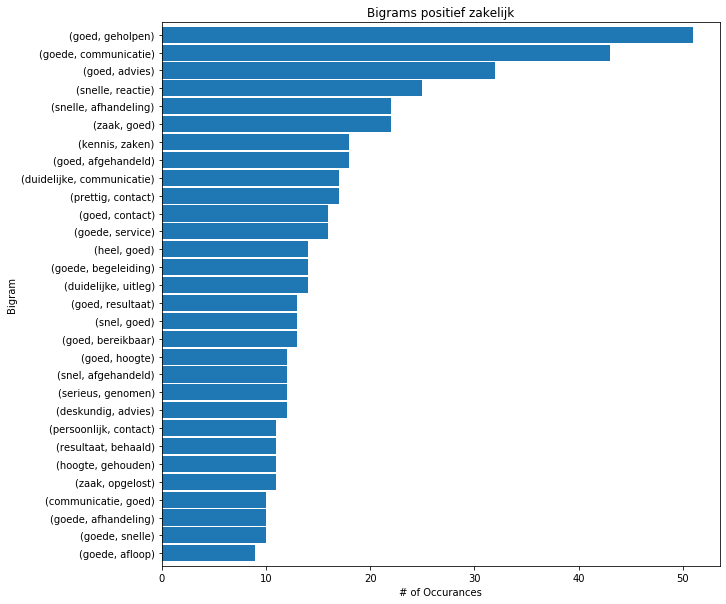

In [57]:
ngram_chart(data_z_pro.bigrams, 30, 'Bigrams positief zakelijk', False)

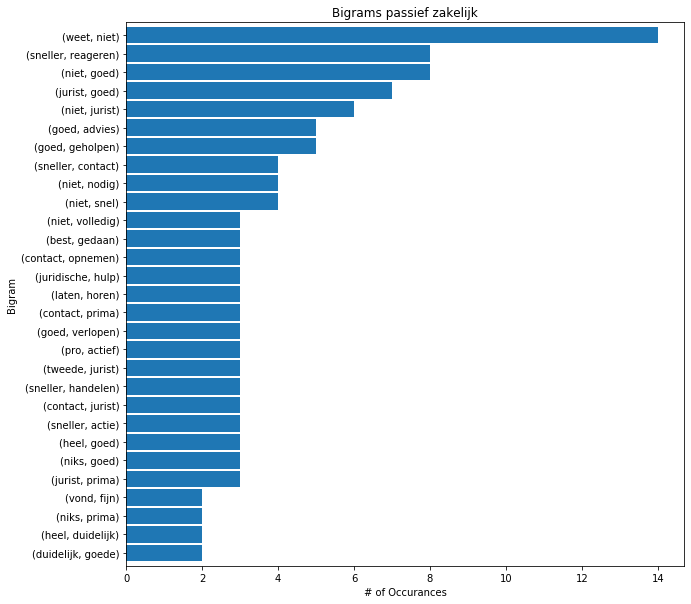

In [58]:
ngram_chart(data_z_pas.bigrams, 30, 'Bigrams passief zakelijk', True)

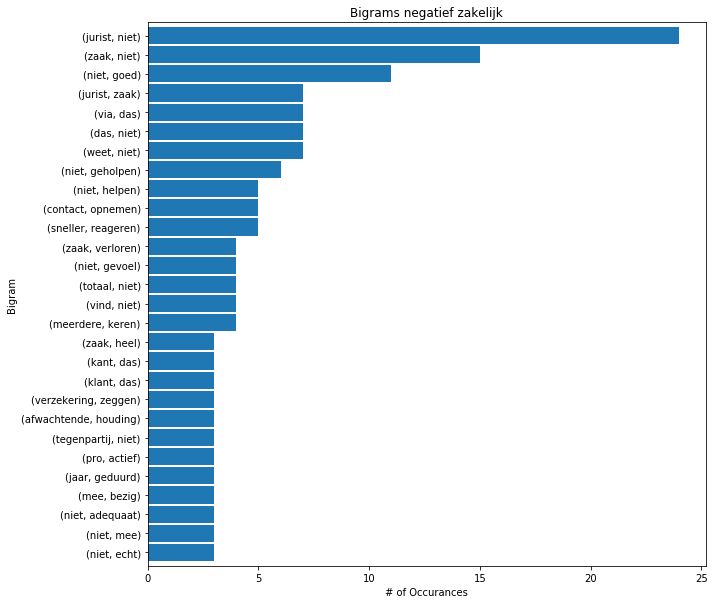

In [59]:
ngram_chart(data_z_det.bigrams, 30, 'Bigrams negatief zakelijk', True)

## Trigrams maken voor particulier

In [60]:
data_p_pro['trigrams'] = data_p_pro['clean_lemmas'].apply(lambda x: seq_ngrams(x, 3))
data_p_pro.head()

C:\Users\kvandoorn\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


ID                       NPS               GEVOEL     variable  \
1   1                         9  Overwegend positief  NPSPROMOTER   
4   4  10 = zeer waarschijnlijk             Neutraal  NPSPROMOTER   
5   5  10 = zeer waarschijnlijk  Overwegend positief  NPSPROMOTER   
7   7                         9  Overwegend positief  NPSPROMOTER   
9   9                         9  Overwegend positief  NPSPROMOTER   

                                                                                                                              value  \
1  De service was heel erg goed. Ze bleven goed in contact en antwoorden altijd op tijd terug. Ze krijgen dingen ook goed geregeld.   
4                                                                                   Hele fijne vrouw die mij begrijpt en goed helpt   
5                                                                                          Duidelijke communicatie en snel reageren   
7                                                                              Goed luisteren en meedenken én ….ze sprak italiaans!   
9                                                              Geschertste probleem werd snel en vakkundig opgenomen en beeantwoord   

                                                                                                         clean  \
1  [service, heel, erg, goed, bleven, goed, contact, antwoorden, tijd, terug, krijgen, dingen, goed, geregeld]   
4                                                                        [fijne, vrouw, begrijpt, goed, helpt]   
5                                                                   [duidelijke, communicatie, snel, reageren]   
7                                                               [goed, luisteren, meedenken, sprak, italiaans]   
9                                             [geschertste, probleem, snel, vakkundig, opgenomen, beeantwoord]   

                                                                                                                                                                                                   bigrams  \
1  [(service, heel), (heel, erg), (erg, goed), (goed, blijven), (blijven, goed), (goed, contact), (contact, antwoorden), (antwoorden, tijd), (tijd, terug), (terug, krijgen), (krijgen, dingen), (dinge...   
4                                                                                                                                   [(fijn, vrouw), (vrouw, begrijpen), (begrijpen, goed), (goed, helpen)]   
5                                                                                                                                      [(duidelijk, communicatie), (communicatie, snel), (snel, reageren)]   
7                                                                                                                  [(goed, luisteren), (luisteren, meedenken), (meedenken, spreken), (spreken, italiaans)]   
9                                                                                         [(geschertste, probleem), (probleem, snel), (snel, vakkundig), (vakkundig, opgenomen), (opgenomen, beeantwoord)]   

                                                                                                   clean_lemmas  \
1  [service, heel, erg, goed, blijven, goed, contact, antwoorden, tijd, terug, krijgen, dingen, goed, geregeld]   
4                                                                        [fijn, vrouw, begrijpen, goed, helpen]   
5                                                                     [duidelijk, communicatie, snel, reageren]   
7                                                              [goed, luisteren, meedenken, spreken, italiaans]   
9                                              [geschertste, probleem, snel, vakkundig, opgenomen, beeantwoord]   

                                                                                                                                                                    

In [61]:
data_p_pas['trigrams'] = data_p_pas['clean_lemmas'].apply(lambda x: seq_ngrams(x, 3))
data_p_det['trigrams'] = data_p_det['clean_lemmas'].apply(lambda x: seq_ngrams(x, 3))

C:\Users\kvandoorn\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\kvandoorn\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [62]:
def count_opschonen_tri(series):
    rijen = []
    count = 0
    for x in range(0, len(series.index)):
        for y in range(x + 1, len(series.index)):
            if series.index[x][0] in series.index[y]:
                count += 1
                if series.index[x][1] in series.index[y]:
                    count += 1
                    if series.index[x][2] in series.index[y]:
                        count += 1
            if count == 3:
                series[x] += series[y]
                rijen.append(y)
            count = 0
    series.drop(series.index[rijen], inplace=True)
    return(series)

In [63]:
def ngram_chart_tr(series, terms=30, name='', save=False):
    ngrams_list = series.explode().value_counts().head(terms)
    ngrams_list = count_opschonen_tri(ngrams_list)
    ngrams_list.sort_values().plot.barh(width=.9, figsize=(10, 10))
    ngrams_list_full = series.explode().value_counts()
    ngrams_list_full.to_csv(name + '.csv', sep=";")
    count_opschonen_tri(ngrams_list[:100]).to_csv(name + '_top100.csv', sep=";")
    plt.title(name)
    plt.ylabel('Trigram')
    plt.xlabel('# of Occurances')
    if save:
        plt.savefig(name + '.png', bbox_inches='tight')

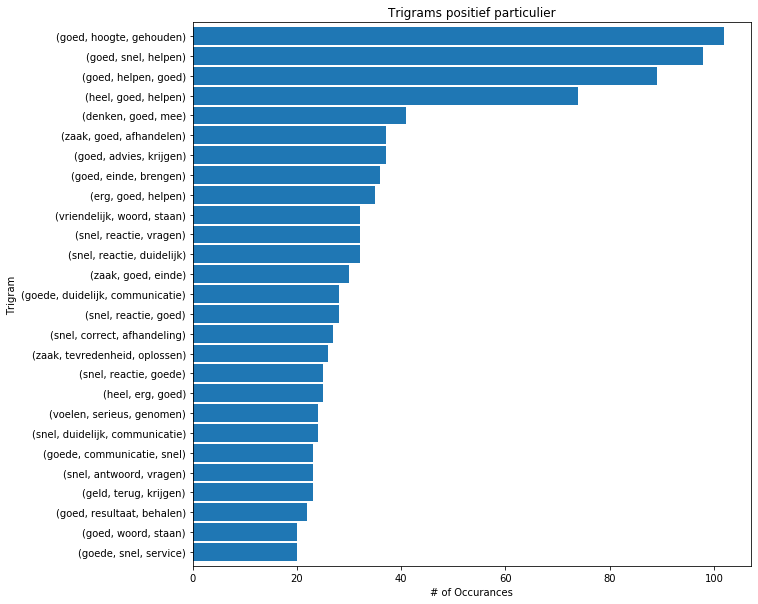

In [64]:
ngram_chart_tr(data_p_pro.trigrams, 30, 'Trigrams positief particulier', True)

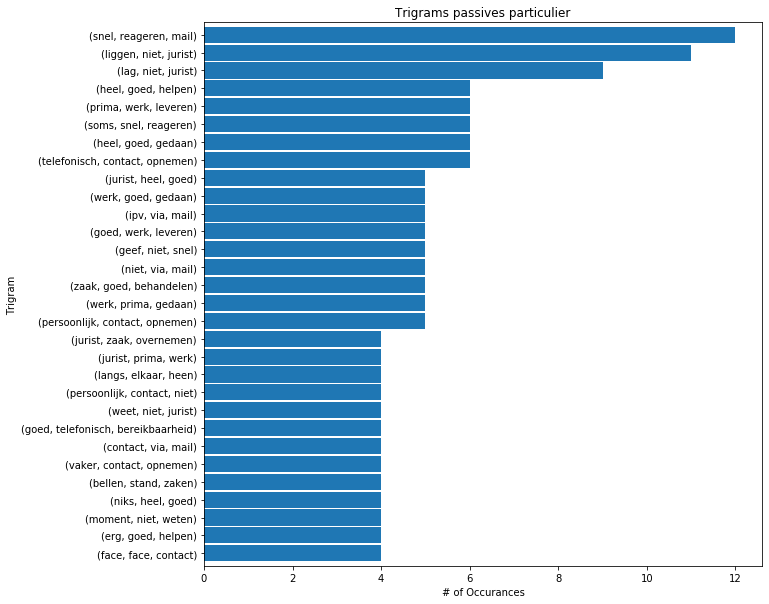

In [65]:
ngram_chart_tr(data_p_pas.trigrams, 30, 'Trigrams passives particulier', True)

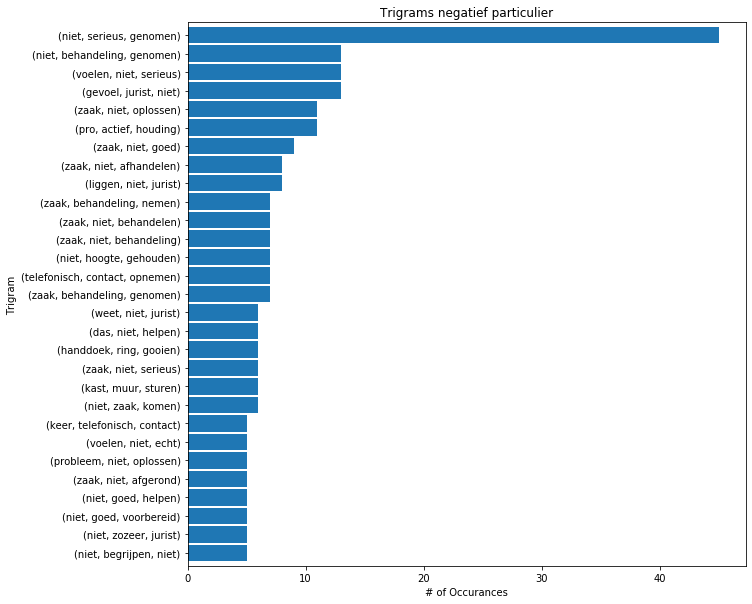

In [69]:
ngram_chart_tr(data_p_det.trigrams, 30, 'Trigrams negatief particulier', True)

## Trigrams voor zakelijk

In [66]:
data_z_pro['trigrams'] = data_z_pro['clean_lemmas'].apply(lambda x: seq_ngrams(x, 3))
data_z_pas['trigrams'] = data_z_pas['clean_lemmas'].apply(lambda x: seq_ngrams(x, 3))
data_z_det['trigrams'] = data_z_det['clean_lemmas'].apply(lambda x: seq_ngrams(x, 3))
data_z_det.head()

C:\Users\kvandoorn\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\kvandoorn\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\kvandoorn\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

ID                        NPS               GEVOEL       variable  \
4418   2  0 = zeer onwaarschijnlijk  Overwegend negatief  NPSDETRACTORS   
4440  24                          5             Neutraal  NPSDETRACTORS   
4450  34                          1  Overwegend negatief  NPSDETRACTORS   
4455  39                          6             Neutraal  NPSDETRACTORS   
4476  60                          6  Overwegend negatief  NPSDETRACTORS   

                                                                                                                                                   value  \
4418                                                                                         Belangen behartige. Ik ben niet of niet voldoende geholpen.   
4440        sneller schakelen, ik bedoel dan de jurist die de zaak het langste in behandeling heeft gehad, ik moest haar steeds herinneren aan voortgang   
4450                                                                                                        moeten helpen--- nu niet aan de zaak gekeken   
4455                                                                                                                                         Meer advies   
4476  duidelijker communiceren. Er is veel onduidelijk gebleven. Met zeer grote tijden met stiltes. waarin je niet geïnformeerd wordt, wat de status is.   

                                                                                                               clean  \
4418                                                          [belangen, behartige, niet, niet, voldoende, geholpen]   
4440                                  [sneller, schakelen, bedoel, jurist, zaak, behandeling, herinneren, voortgang]   
4450                                                                                           [niet, zaak, gekeken]   
4455                                                                                                        [advies]   
4476  [duidelijker, communiceren, onduidelijk, gebleven, grote, tijden, stiltes, waarin, niet, geinformeerd, status]   

                                                                                                                                                                                                      bigrams  \
4418                                                                                                       [(belangen, behartige), (behartige, niet), (niet, niet), (niet, voldoende), (voldoende, geholpen)]   
4440                                                   [(sneller, schakelen), (schakelen, bedoel), (bedoel, jurist), (jurist, zaak), (zaak, behandeling), (behandeling, herinneren), (herinneren, voortgang)]   
4450                                                                                                                                                                          [(niet, zaak), (zaak, gekeken)]   
4455                                                                                                                                                                                                       []   
4476  [(duidelijker, communiceren), (communiceren, onduidelijk), (onduidelijk, gebleven), (gebleven, grote), (grote, tijden), (tijden, stiltes), (stiltes, waarin), (waarin, niet), (niet, geinformeerd), ...   

                                                                                                    clean_lemmas  \
4418                                                        [belangen, behartige, niet, niet, voldoende, helpen]   
4440                               [snel, schakelen, bedoelen, jurist, zaak, behandeling, herinneren, voortgang]   
4450                                                                                        [niet, zaak, kijken]   
4455                                                                                                    [advies]   
4476  [duidelijk, communiceren, onduidelijk, blijven, grote, t

In [67]:
ngram_chart_tr(data_z_pro.trigrams, 30, 'Trigrams positief zakelijk', True)

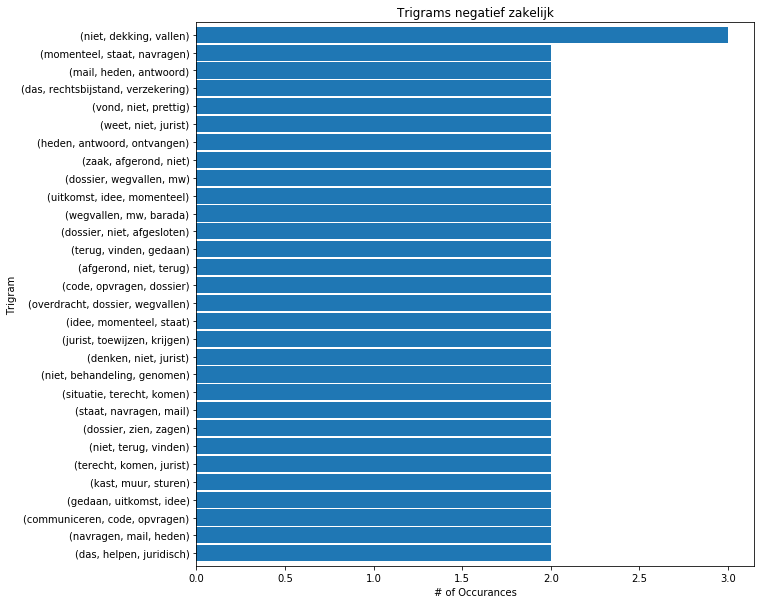

In [68]:
ngram_chart_tr(data_z_det.trigrams, 30, 'Trigrams negatief zakelijk', True)

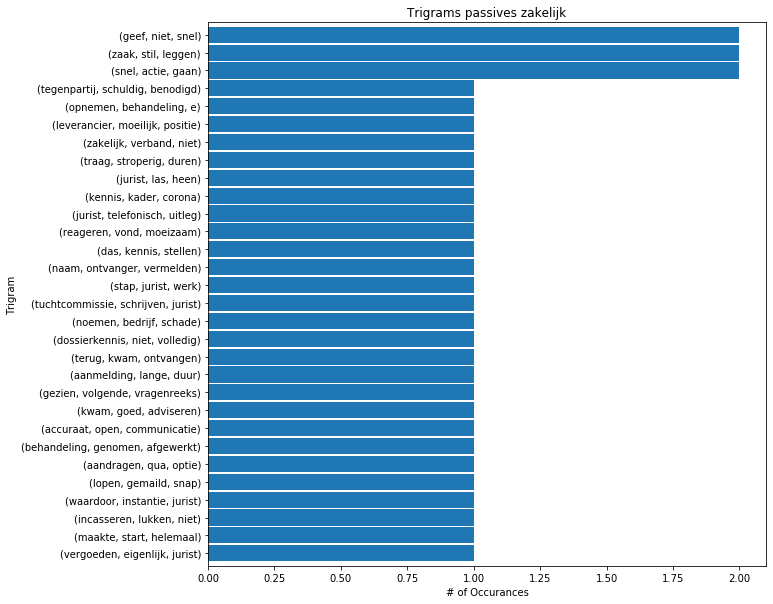

In [69]:
ngram_chart_tr(data_z_pas.trigrams, 30, 'Trigrams passives zakelijk', True)

## Data opslaan

In [70]:
data_p_pro.to_excel('data_particulier_positief.xlsx')
data_p_pas.to_excel('data_particulier_passives.xlsx')
data_p_det.to_excel('data_particulier_negatief.xlsx')

In [71]:
data_z_pro.to_excel('data_zakelijk_positief.xlsx')
data_z_pas.to_excel('data_zakelijk_passives.xlsx')
data_z_det.to_excel('data_zakelijk_negatief.xlsx')